<>:7: SyntaxWarning: invalid escape sequence '\S'
<>:7: SyntaxWarning: invalid escape sequence '\S'
C:\Users\ramco\AppData\Local\Temp\ipykernel_22696\36511668.py:7: SyntaxWarning: invalid escape sequence '\S'
  DB = {'servername': 'RAMCO\SQLEXPRESS',
C:\Users\ramco\AppData\Local\Temp\ipykernel_22696\36511668.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  orders_df = pd.read_sql_query("SELECT OrderKey, OrderID FROM dbo.Sales", export_conn)
C:\Users\ramco\AppData\Local\Temp\ipykernel_22696\36511668.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  order_details_df = pd.read_sql_query("SELECT OrderKey, UnitPrice, Quantity FROM dbo.Sales", export_conn)


Average Order Value: 899.9641139875575


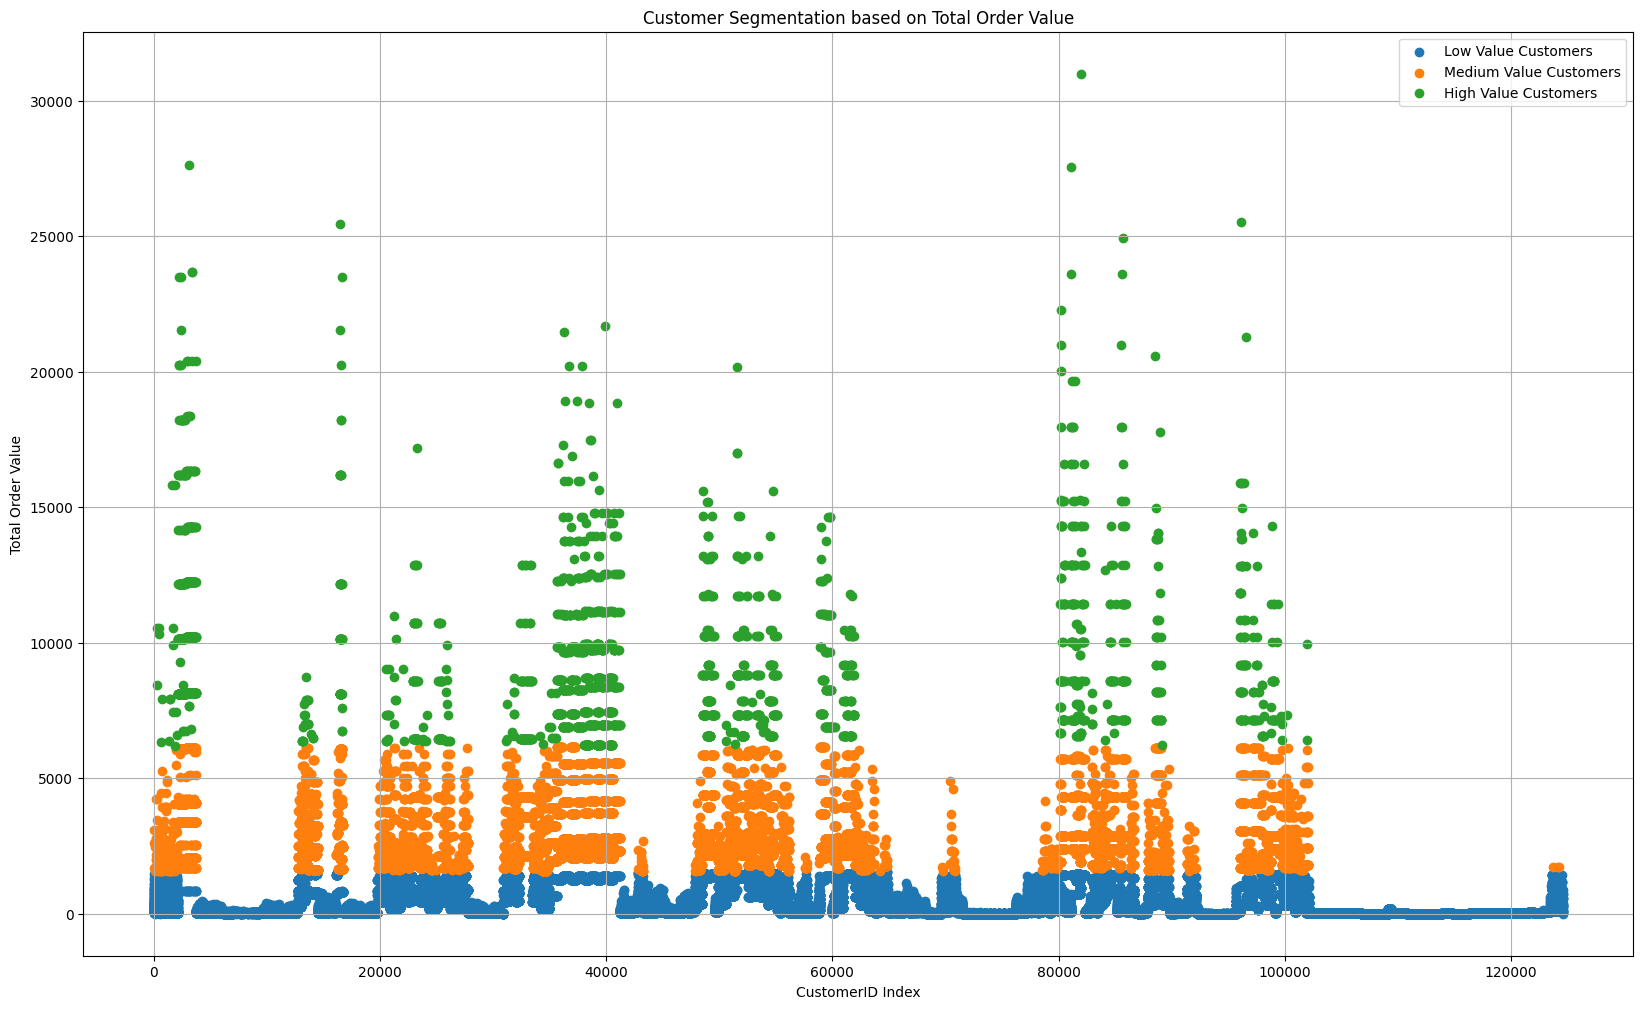

In [1]:
import pyodbc
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Connection details for UnitedoutdoorsDWH database
DB = {'servername': 'RAMCO\SQLEXPRESS',
      'database': 'UnitedoutdoorsDWH'}

export_conn = pyodbc.connect(
    'DRIVER={SQL Server};SERVER=' + DB['servername'] + ';DATABASE=' + DB['database'] + ';Trusted_Connection=yes')

# Fetch relevant data from the database
orders_df = pd.read_sql_query("SELECT OrderKey, OrderID FROM dbo.Sales", export_conn)
order_details_df = pd.read_sql_query("SELECT OrderKey, UnitPrice, Quantity FROM dbo.Sales", export_conn)

# Calculate total order value for each order
order_details_df['OrderValue'] = order_details_df['UnitPrice'] * order_details_df['Quantity']

# Merge orders and order details to calculate total order value per order
merged_orders_df = pd.merge(orders_df, order_details_df, on='OrderKey', how='left')

average_order_value = merged_orders_df.groupby('OrderKey')['OrderValue'].sum().mean()
print(f"Average Order Value: {average_order_value}")

# Calculate the total order value per customer (assuming EmployeeKey as CustomerID)
customer_order_value = merged_orders_df.groupby('OrderKey')['OrderValue'].sum().reset_index()

# Fit the KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42).fit(customer_order_value[['OrderValue']])
customer_order_value['Segment'] = kmeans.labels_

# Name the segments
segment_names = {0: 'Low Value Customers', 1: 'Medium Value Customers', 2: 'High Value Customers'}
customer_order_value['SegmentName'] = customer_order_value['Segment'].map(segment_names)

# Visualize customer segments
plt.figure(figsize=(20, 12))
for segment in customer_order_value['Segment'].unique():
    segment_data = customer_order_value[customer_order_value['Segment'] == segment]
    plt.scatter(segment_data.index, segment_data['OrderValue'], label=segment_names[segment])

plt.xlabel('CustomerID Index')
plt.ylabel('Total Order Value')
plt.title('Customer Segmentation based on Total Order Value')
plt.legend()
plt.grid(True)
plt.show()
